In [603]:
import cv2 as cv
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt

In [604]:
#T = cv.imread(r'data\traffic-stop-signs\template-x-2.png')
T1 = cv.imread(r'data\traffic-stop-signs\template-1-2.png')
#T_pic = cv.cvtColor(T, cv.COLOR_BGR2RGB)
T1 = cv.resize(T1, (64,64))

T2 = cv.imread(r'data\traffic-stop-signs\template-x-2.png')
T2 = cv.resize(T2, (64,64))

T3 = cv.imread(r'data\traffic-stop-signs\template-1-0.png')
T3 = cv.resize(T3, (64,64))

T4 = cv.imread(r'data\traffic-stop-signs\template-x-1.png')
T4 = cv.resize(T3, (64,64))


#plt.title('Template')
#plt.imshow(T, cmap='gray');

In [605]:
I1 = cv.imread('data/traffic-stop-signs/traffic-stop-1.jpg')
I1_pic = cv.cvtColor(I1, cv.COLOR_BGR2RGB)

I2 = cv.imread('data/traffic-stop-signs/open-road.jpg')
I2_pic = cv.cvtColor(I2, cv.COLOR_BGR2RGB)

I3 = cv.imread('data/traffic-stop-signs/traffic-stop-4.jpg')
I3_pic = cv.cvtColor(I3, cv.COLOR_BGR2RGB)

I4 = cv.imread('data/traffic-stop-signs/traffic-stop-7.jpg')
I4_pic = cv.cvtColor(I4, cv.COLOR_BGR2RGB)

I5 = cv.imread('data/traffic-stop-signs/traffic-stop-3.jpg')
I5_pic = cv.cvtColor(I5, cv.COLOR_BGR2RGB)

I6 = cv.imread('data/traffic-stop-signs/traffic-stop-2.jpeg')
I6_pic = cv.cvtColor(I6, cv.COLOR_BGR2RGB)

I7 = cv.imread('data/traffic-stop-signs/traffic-stop-6.jpg')
I7_pic = cv.cvtColor(I7, cv.COLOR_BGR2RGB)



#print(I.shape)

#plt.title('Image')
#plt.imshow(I_pic)

In [606]:
#Makes color red stand out the most
def extract_red(I, T):
    I_copy = I.copy()
    T_copy = T.copy()
    I_copy = cv.cvtColor(I_copy, cv.COLOR_BGR2HSV)
    T_copy = cv.cvtColor(T_copy, cv.COLOR_BGR2HSV)

    lower = np.array([0,150,150])
    upper = np.array([180,255,255])
    I_copy = cv.inRange(I_copy, lower, upper)
    T_copy = cv.inRange(T_copy, lower, upper)

    #plt.subplot(121),plt.imshow(I_copy)
    #plt.subplot(122),plt.imshow(T_copy)
    #plt.show()
    return I_copy, T_copy

In [607]:
def highlight(R, T, I, use_max=True):
    """
    Finds the location of maximum (or minimum) matching response, and 
    draws a rectangle on the image around this location.  The
    size of the rectangle is determined by template T.
    
    Returns an image with the drawn rectangle.  Also returns the loc and
    the value (maximum or minimum as the case may be).  The original image
    remains unchanged.
    """
    
    W, H = I.shape[0], I.shape[1]
    w, h = T.shape[0], T.shape[1]
    wr, hg = R.shape[0], R.shape[1]
        
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(R)
    loc = max_loc if use_max else min_loc
    val = max_val if use_max else min_val
    
    loc1 = loc + np.array([h//2, w//2])               # Size of R is different from I 
    tl = loc1 - np.array([h//2, w//2])
    br = loc1 + np.array([h//2, w//2])
    I_ = np.copy(I)
    c = (1.0, 0, 0) if I_.dtype == 'float32' else (255, 0, 0)
    cv.rectangle(I_, tuple(tl), tuple(br), c, 4)
    return I_, loc, val


############### include scaling for different sized images - n being how many times got cut in half. Used for testing

def highlight_original(R, T, I, n, use_max=True):
 
    W, H = I.shape[0], I.shape[1]
    w, h = T.shape[0], T.shape[1]
    wr, hg = R.shape[0], R.shape[1]
        
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(R)
    loc = max_loc if use_max else min_loc
    val = max_val if use_max else min_val
    
    loc1 = loc + np.array([h//2, w//2])               # Size of R is different from I 
    tl = loc1 - np.array([h//2, w//2])
    br = loc1 + np.array([h//2, w//2])
    I_ = np.copy(I)
    c = (1.0, 0, 0) if I_.dtype == 'float32' else (255, 0, 0)
    cv.rectangle(I_, tuple(tl * n), tuple(br * n), c, 4)
    return I_, loc, val





In [608]:
#Custom function
def get_bounds(R, T, I, n,  use_max=True):
    W, H = I.shape[0], I.shape[1]
    w, h = T.shape[0], T.shape[1]
    wr, hg = R.shape[0], R.shape[1]
        
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(R)
    loc = max_loc if use_max else min_loc
    val = max_val if use_max else min_val
    
    loc1 = loc + np.array([h//2, w//2])               # Size of R is different from I 
    tl = loc1 - np.array([h//2, w//2])
    br = loc1 + np.array([h//2, w//2])
    
    first_coord = tl * n
    second_coord = (br * n) - first_coord #Gets relative position
    coords = np.append(first_coord, second_coord)
    
    return coords, loc, val

In [609]:
def find_loc_and_value_in_R(R, use_max=True):
    """
    Finds the location of maximum (or minimum) matching response.
    """
    
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(R)
    loc = max_loc if use_max else min_loc
    val = max_val if use_max else min_val
    
    return loc, val

In [610]:
def draw_rect(I, bbox):

    I_ = np.copy(I)
    c = (1.0, 0, 0) if I_.dtype == 'float32' else (255, 0, 0)
    cv.rectangle(I_, bbox, c, 4)
    return I_

In [611]:
def gen_gaussian_pyramid(I, levels):
    G = I.copy()
    gpI = [G]
    for i in range(levels):
        G = cv.pyrDown(G)
        gpI.append(G)
    return gpI

In [612]:
def visualize_guassian_pyramid(gpI):
    I = gpI[0]
    h, w = I.shape[0], I.shape[1]
    
    if len(I.shape) == 3:
        result = np.empty([h, 2*w, I.shape[2]], dtype=I.dtype)
    else:
        result = np.empty([h, 2*w], dtype=I.dtype)
    
    x = 0
    for I_ in gpI:
        if len(I.shape) == 3:
            h, w, _ = I_.shape
            result[:h,x:x+w,:] = I_
        else:
            h, w = I_.shape
            result[:h,x:x+w] = I_
        x += w
    
    return result

In [613]:
def make_square(I):
    h = I.shape[0]
    w = I.shape[1]
    
    n_levels = np.int(np.ceil(np.log(np.max([h,w]))/np.log(2)))
    new_h = np.power(2, n_levels)
    new_w = new_h
    
    if len(I.shape) == 3:
        tmp = np.zeros([new_h, new_w, I.shape[2]], dtype=I.dtype)
        tmp[:h,:w,:] = I
    else:
        tmp = np.zeros([new_h, new_w], dtype=I.dtype)
        tmp[:h,:w] = I

    return tmp, n_levels

In [614]:
def find_stop_sign(T, I):
    """
    Given a traffic stop sign template T and an image I, returns the bounding box 
    for the detected stop sign.
    
    A bounding box is defined as follows: [top, left, height, width]
    
    You may return an empty bounding box [0,0,1,1] to indicate that a 
    stop sign wasn't found.
    """
    
    I, T = extract_red(I, T)
    
    
    sqr_img, levels = make_square(I)
    #print(levels)
    gp = gen_gaussian_pyramid(sqr_img, levels)
    '''
    plt.figure(figsize=(10,10))
    plt.title('Image')
    plt.imshow(visualize_guassian_pyramid(gp), cmap='gray')
    plt.xticks([])
    plt.yticks([]);
    '''
    
    index = 1
    max_values = [0,0,1,1]
    max_value = 0
    for img in gp:
        #print(T.shape <= img.shape)
        #print("T: ", T.shape, " img: ", img.shape)
        
        #Only does below code if image is bigger then the template
        if img.shape > T.shape:
            method = 'cv.TM_CCOEFF_NORMED'
            R = cv.matchTemplate(img, T, eval(method))
            ##I_, loc, val = highlight(R, T, img, use_max=True)
            #I_, loc, val = highlight_original(R, T, I, index, use_max=True)
            coords, loc, val = get_bounds(R, T, I, index, use_max=True)
            #print(val)
              
            if val > 0.38 and val > max_value:
                print(val)
                max_values = coords
                max_value = val
        index += 1

        
    return max_values
    

<h1>Test cases Below</h1>

0.5488573908805847
Bbox = [410 230 128 128]
0.38141873478889465
Bbox = [450 281  64  64]
0.5828210711479187
Bbox = [410 234 128 128]
Bbox = [0, 0, 1, 1]
0.473446786403656
Bbox = [440 370 128 128]
0.6254381537437439
Bbox = [836 178 128 128]
0.5896392464637756
Bbox = [ 72  36 128 128]
0.513227641582489
Bbox = [146  12  64  64]


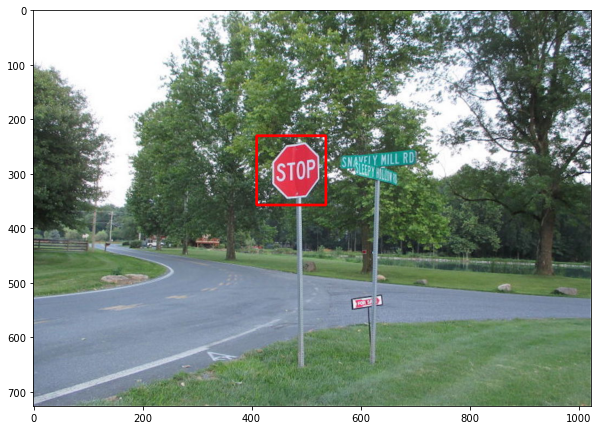

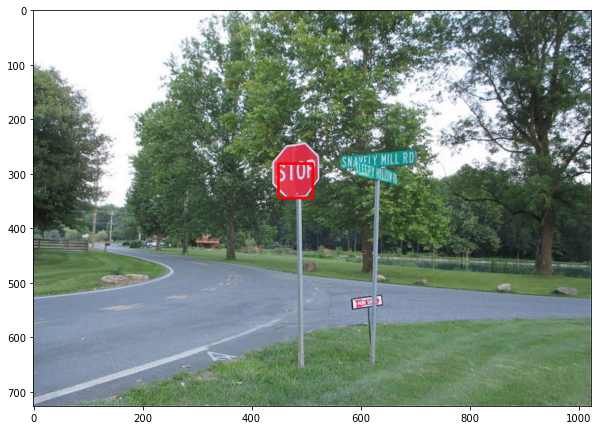

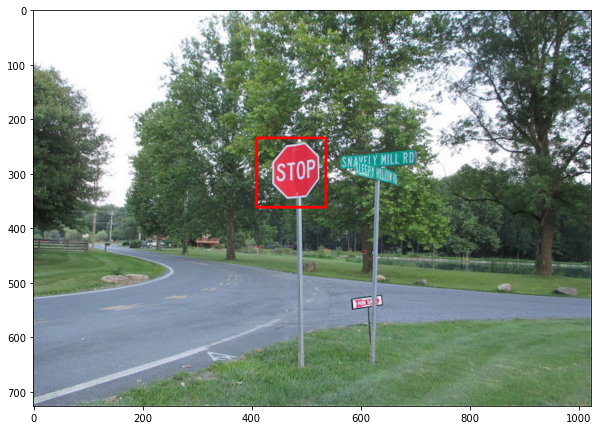

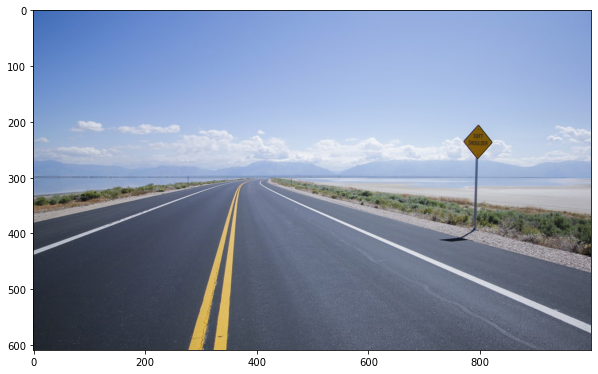

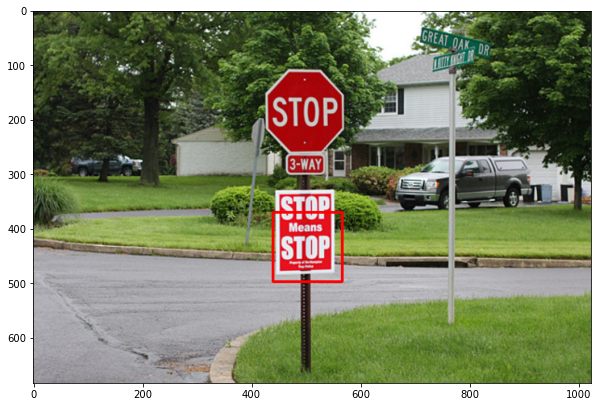

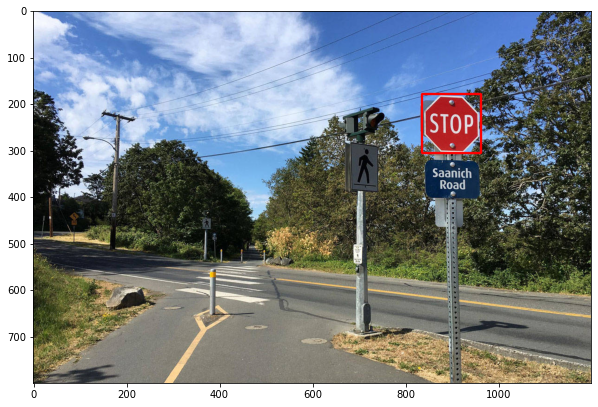

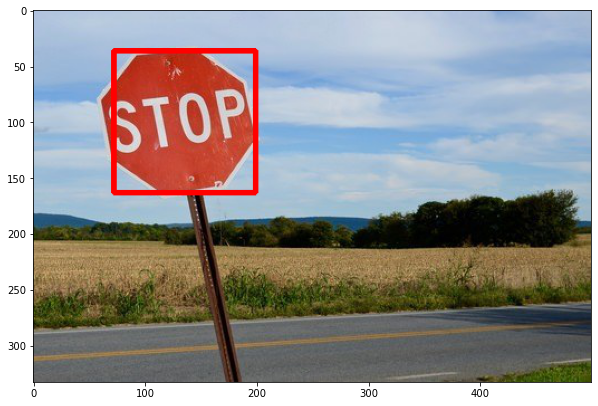

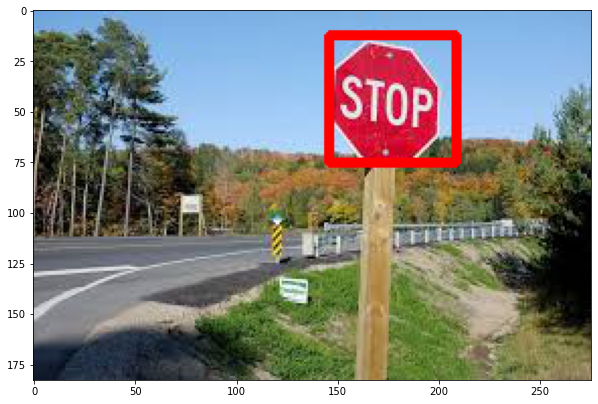

In [615]:

#First
bbox = find_stop_sign(T1, I1)
print(f'Bbox = {bbox}')

plt.figure(figsize=(10,10))
I_ = draw_rect(I1_pic, bbox)
plt.imshow(I_, cmap='gray');

#Second
bbox = find_stop_sign(T2, I1)
print(f'Bbox = {bbox}')

plt.figure(figsize=(10,10))
I_ = draw_rect(I1_pic, bbox)
plt.imshow(I_, cmap='gray');

#Third
bbox = find_stop_sign(T3, I1)
print(f'Bbox = {bbox}')

plt.figure(figsize=(10,10))
I_ = draw_rect(I1_pic, bbox)
plt.imshow(I_, cmap='gray');

#Fourth
bbox = find_stop_sign(T3, I2)
print(f'Bbox = {bbox}')

plt.figure(figsize=(10,10))
I_ = draw_rect(I2_pic, bbox)
plt.imshow(I_, cmap='gray');

#Fifth
bbox = find_stop_sign(T4, I3)
print(f'Bbox = {bbox}')

plt.figure(figsize=(10,10))
I_ = draw_rect(I3_pic, bbox)
plt.imshow(I_, cmap='gray');

###

#Sixth
bbox = find_stop_sign(T4, I4)
print(f'Bbox = {bbox}')

plt.figure(figsize=(10,10))
I_ = draw_rect(I4_pic, bbox)
plt.imshow(I_, cmap='gray');

#Seventh
bbox = find_stop_sign(T2, I5)
print(f'Bbox = {bbox}')

plt.figure(figsize=(10,10))
I_ = draw_rect(I5_pic, bbox)
plt.imshow(I_, cmap='gray');

#8
bbox = find_stop_sign(T2, I6)
print(f'Bbox = {bbox}')

plt.figure(figsize=(10,10))
I_ = draw_rect(I6_pic, bbox)
plt.imshow(I_, cmap='gray');
